# Implementation of FIR Filter in the FPGA

In [45]:
import numpy as np
from numpy import savetxt, loadtxt
import matplotlib.pyplot as plt

In [124]:
# Let us generate a wave function with two main frequencies, an high one and a low one:

data_size = 300
noise = 1 # the higher the noisier
file = open("../signal.txt", "w")


input_sig = []

for i in range(data_size):
    sig = 53*(2+np.sin(i/25)+ noise)
    noise = -noise
    input_sig.append(sig.astype(int)) # we write it as an int
    file.write(str(sig.astype(int)))
    file.write('\n')

file.close()

In [125]:
print(min(input_sig),max(input_sig))

0 211


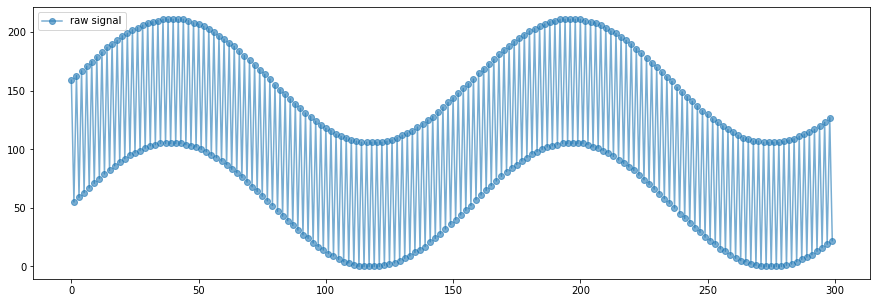

In [126]:
# Now we visualize it:
sig = np.loadtxt("../signal.txt", delimiter='\n')
t = np.arange(len(input_sig)) # array for the x coordinate, just for displaying

plt.figure(figsize=(15, 5))

plt.plot(t, sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

In [70]:
# After being computed on the actual FPGA

In [28]:
# I just copied from the terminal, had some problems in reading from a file :/
fpga = [0,0,0,0,-1,-8,-2,-1,0,1,1,2,2,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,11,12,12,12,12,13,13,13,13,14,14,14,14,14,14,14,14,14,14,14,14,13,13,13,13,13,12,12,12,11,11,11,10,10,10,9,9,8,8,7,7,6,6,5,4,4,3,3,2,2,1,0,0,-1,-2,-2,-3,-3,-4,-5,-5,-6,-6,-7,-8,-8,-9,-9,-10,-10,-11,-11,-12,-12,-13,-13,-14,-14,-14,-15,-15,-15,-16,-16,-13,13,16,15,15,15,15,15,15,15,15,15,15,15,15,15,15,16,13,-13,-16,-15,-15,-15,-14,-14,-14,-13,-13,-13,-12,-12,-11,-11,-10,-10,-9,-8,-8,-7,-7,-6,-6,-5,-4,-4,-3,-3,-2,-1,-1,0,1,1,2,2,3,3,4,5,5,6,6,5,-8,-12,-12,-11,-10,-9,-9,-8,-8,-7,-6,-6,-6,-5,-5,-5,-4,-4,-4,-3,-3,-3]
for i in range(len(fpga)):
    # 2**10 due to truncation of bits
    # 2**9 because I multiplied the coefficients by 2**9
    fpga[i] = (2**10/2**8)*fpga[i]+ 127

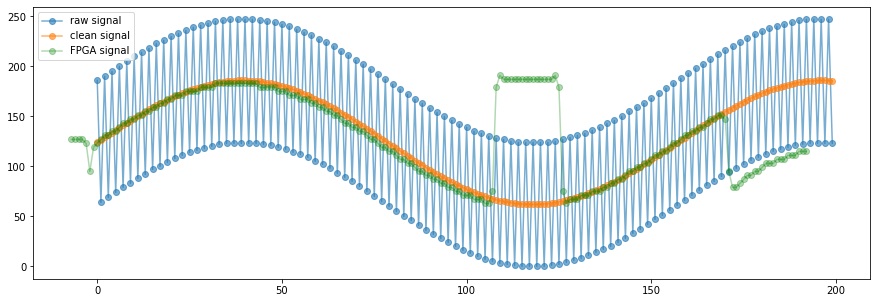

In [31]:
plt.figure(figsize=(15, 5))

t = np.arange(len(input_sig))
plt.plot(t, input_sig, '-o',alpha=.6,label='raw signal')
plt.plot(t, clean_sig, '-o',alpha=.6,label='clean signal')
t = np.arange(len(fpga))
plt.plot(t-7, fpga, '-o', color='g',alpha=.3,label='FPGA signal')

#plt.title("")
#plt.xlim(0,130) #just for the latex report
plt.legend(loc="upper left")